In [10]:
#imports
import numpy as np
import pandas as pd
from HydroModelv2 import hydroPowerList
from MinSpillAdjuster import SpillAdjuster
from HydroFlowAdjustment import flowAdjustment
from WTT import WTT
from SARmodelv3 import SAR_model
from economicsModelv1 import cost
import copy

In [11]:
#SETUP FOR EA
#set up testing data
graniteUpTraining = pd.read_csv(r'Data\TrainingData\GraniteUpTraining.csv', delimiter=',')
graniteDownTraining = pd.read_csv(r'Data\TrainingData\GraniteDownTraining.csv', delimiter=',')
gooseUpTraining = pd.read_csv(r'Data\TrainingData\GraniteUpTraining.csv', delimiter=',')
gooseDownTraining = pd.read_csv(r'Data\TrainingData\GooseDownTraining.csv', delimiter=',')
monumentalUpTraining = pd.read_csv(r'Data\TrainingData\MonumentalUpTraining.csv', delimiter=',')
monumentalDownTraining = pd.read_csv(r'Data\TrainingData\MonumentalDownTraining.csv', delimiter=',')
iceUpTraining = pd.read_csv(r'Data\TrainingData\IceUpTraining.csv', delimiter=',')
iceDownTraining = pd.read_csv(r'Data\TrainingData\IceDownTraining.csv', delimiter=',')
upTouple = [graniteUpTraining,gooseUpTraining,monumentalUpTraining,iceUpTraining]
downTouple = [graniteDownTraining,gooseDownTraining,monumentalDownTraining,iceDownTraining]

#DAM BREACH STATUS
graniteBreach = False
gooseBreach = False
monumentalBreach = False
iceBreach = False
breachTouple = [graniteBreach,gooseBreach,monumentalBreach,iceBreach] #will change for the 16 scenarios

#dam power capacities
graniteCap = 810
gooseCap = 810
monumentalCap = 810
iceCap = 603
maxPowerTouple = [graniteCap,gooseCap,monumentalCap,iceCap]


Evolutionary algorithm below

In [12]:

#choose data year for evaluation
def dataYear(upTouple,downTouple,year):
    filtered_downTouple = []
    filtered_upTouple = []
    for i in range(4):
        upTouple[i]['Date'] = pd.to_datetime(upTouple[i]['Date'])
        downTouple[i]['Date'] = pd.to_datetime(downTouple[i]['Date'])
        newUp = upTouple[i][upTouple[i]['Date'].dt.year==year]
        newDown = downTouple[i][downTouple[i]['Date'].dt.year==year]
        newUp = newUp.reset_index(drop=True)
        newDown = newDown.reset_index(drop=True)
        filtered_downTouple.append(newDown)
        filtered_upTouple.append(newUp)
    return(filtered_upTouple,filtered_downTouple)

year = 2019 #can change
(upTouple,downTouple) = dataYear(upTouple,downTouple,year)

#find baseline energy production
baselineEnergy = sum(hydroPowerList(upTouple,downTouple,maxPowerTouple)['Total Energy (MWh)'])

In [13]:
#more imports
import itertools
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
from functools import partial

In [ ]:
#set up EA

# Define multi-objective fitness
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))  # Minimize both SAR and Economic Impact
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 80)  # Spill range: 0 to 100
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

pd.options.mode.chained_assignment = None  #turn off warnings so I can find errors

# Define dynamic evaluation function
def evaluate(individual, breachTouple, upTouple, downTouple, maxPowerTouple, baselineEnergy, sar_model, econ_model):
    minSpill = individual[0]  # min spill value

    #prevent invalid min spills
    if minSpill > 100:
        # Apply a penalty for invalid values (such as very high fitness or an unreachable solution)
        return (-float('inf'), float('inf'))  # This will result in an invalid individual

    # Adjust touples for spill and breach
    (newUpTouple, newDownTouple) = SpillAdjuster(copy.deepcopy(upTouple), copy.deepcopy(downTouple), minSpill)
    (newUpTouple, newDownTouple) = flowAdjustment(newUpTouple, newDownTouple, breachTouple)

    # Evaluate SAR model
    sar_result = sar_model(newDownTouple, breachTouple)
    # Evaluate economic model
    econ_result = econ_model(newUpTouple, newDownTouple, breachTouple, maxPowerTouple, baselineEnergy)

    fitness = sar_result.item(), econ_result
    if sum(breachTouple)==0:
        print(f"Evaluating Individual {individual} -> Fitness: {fitness}")

    return (fitness)

#copy code for NSGA2 because it can't be imported
def run_nsga2(breachTouple, upTouple, downTouple, maxPowerTouple, baselineEnergy, sar_model, econ_model):
    # Dynamically adapt the evaluation function
    eval_func = partial(
        evaluate,
        breachTouple=breachTouple,
        upTouple=upTouple,
        downTouple=downTouple,
        maxPowerTouple=maxPowerTouple,
        baselineEnergy=baselineEnergy,
        sar_model=sar_model,
        econ_model=econ_model
    )
    toolbox.register("evaluate", eval_func)

    # Create population
    population = toolbox.population(n=25) #change for speed

    # Run NSGA-II
    algorithms.eaMuPlusLambda(
        population=population,
        toolbox=toolbox,
        mu=20, #change for speed
        lambda_=40, #change for speed
        cxpb=0.65,
        mutpb=0.25,
        ngen=15, #change for speed
        stats=None,
        halloffame=None,
        verbose=False,
    )

    # Extract Pareto front
    pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
    return pareto_front

# Dam Breach Scenarios
dams = ["LGR", "LGS", "LMN", "ICE"]
combinations = list(itertools.product([0, 1], repeat=len(dams)))  # All dam breach combinations

c:\Users\aidan\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\aidan\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [15]:
pareto_results = []
for scenario in combinations:
    dams_destroyed = [dams[i] for i in range(len(dams)) if scenario[i] == 1]
    pareto_front = run_nsga2(scenario, upTouple, downTouple, maxPowerTouple, baselineEnergy, SAR_model, cost)

    pareto_results.append({
        "scenario": dams_destroyed,
        "pareto_front": [(ind[0], ind.fitness.values) for ind in pareto_front]
    })

Evaluating Individual [60.53822430887756] -> Fitness: (0.025459360365557, 301068490.1659349)
Evaluating Individual [66.92717424463639] -> Fitness: (0.02595681126811543, 361825537.5566177)
Evaluating Individual [15.952175503510109] -> Fitness: (0.019463190662260037, 51417343.99861037)
Evaluating Individual [4.833998869769545] -> Fitness: (0.015043791888936476, 15366747.60109582)
Evaluating Individual [5.159018601517573] -> Fitness: (0.015233710682356284, 16410336.757282354)
Evaluating Individual [56.28301701723811] -> Fitness: (0.025077839495726447, 263997054.46364245)
Evaluating Individual [56.023893655221464] -> Fitness: (0.02505543446452147, 261815871.78121778)
Evaluating Individual [66.92717424463639] -> Fitness: (0.02595681126811543, 361825537.5566177)
Evaluating Individual [7.355316407396385] -> Fitness: (0.0163898301415641, 23488515.797239214)
Evaluating Individual [92.18700891516706] -> Fitness: (0.0273815713093147, 626995698.4357622)
Evaluating Individual [0.09085485720380415] 

In [16]:
print(pareto_results[0]['pareto_front'])

[(-16.640413447613547, (0.011486775990230869, 0.0)), (-15.010528853047651, (0.011486775990230869, 0.0)), (95.12701499735842, (0.027507641255643023, 658159380.1225506)), (66.08966355600836, (0.025890519048292454, 353590376.1745045)), (15.952175503510109, (0.019463190662260037, 51417343.99861037))]


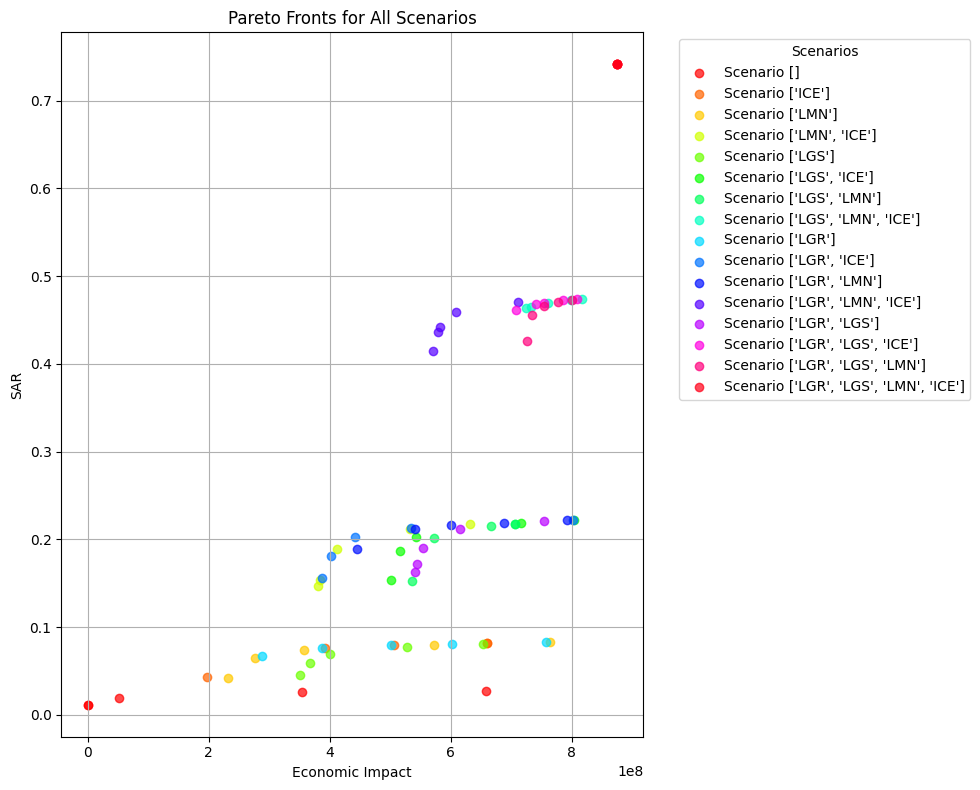

In [17]:
# Define a colormap for different scenarios
colors = plt.cm.hsv(np.linspace(0, 1, len(pareto_results)))  # You can choose any colormap

plt.figure(figsize=(10, 8))

# Loop through all the pareto results and plot on the same graph
for idx, result in enumerate(pareto_results):
    scenario = result["scenario"]
    pareto_front = result["pareto_front"]

    # Extract SAR and economic values for each point in the Pareto front
    sar_values = [fitness[0] for _, fitness in pareto_front]  # SAR values
    econ_values = [fitness[1] for _, fitness in pareto_front]  # Economic values

    # Plot the points for this scenario (all Pareto front points for the scenario)
    plt.scatter(econ_values, sar_values, label=f"Scenario {scenario}", color=colors[idx], alpha=0.7)

# Customize the plot
plt.title("Pareto Fronts for All Scenarios")
plt.xlabel("Economic Impact")
plt.ylabel("SAR")
plt.legend(title="Scenarios", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

    

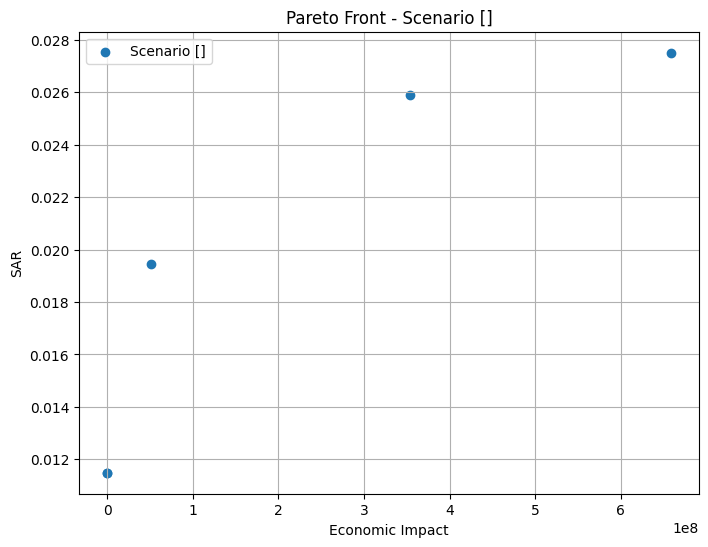

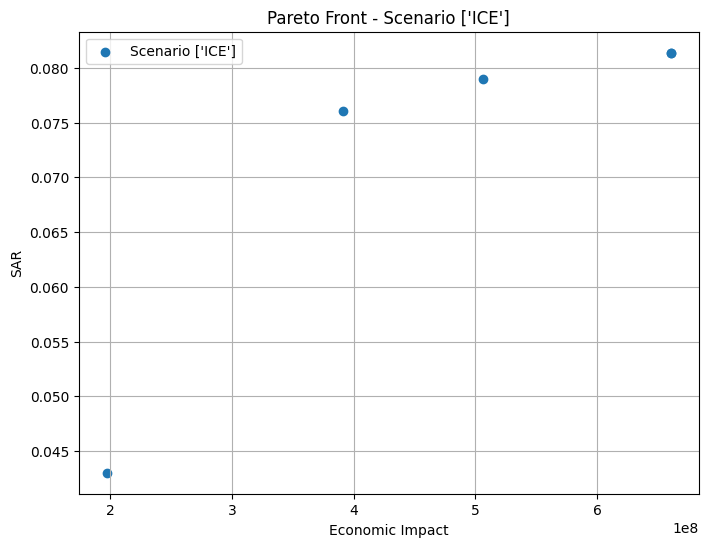

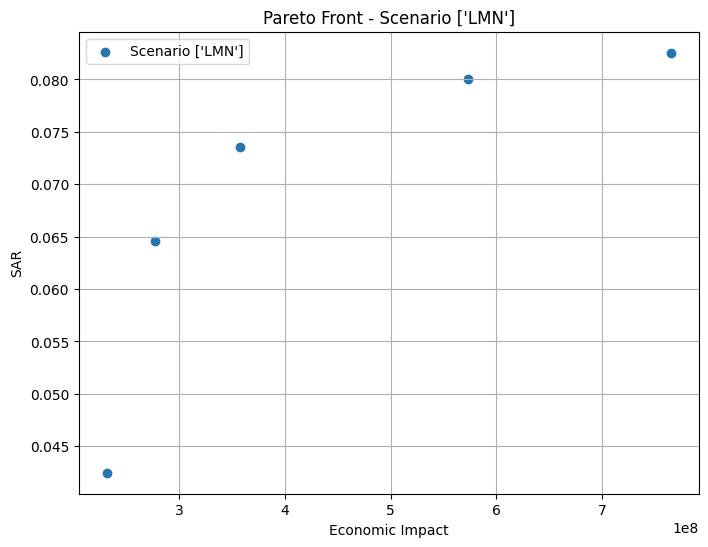

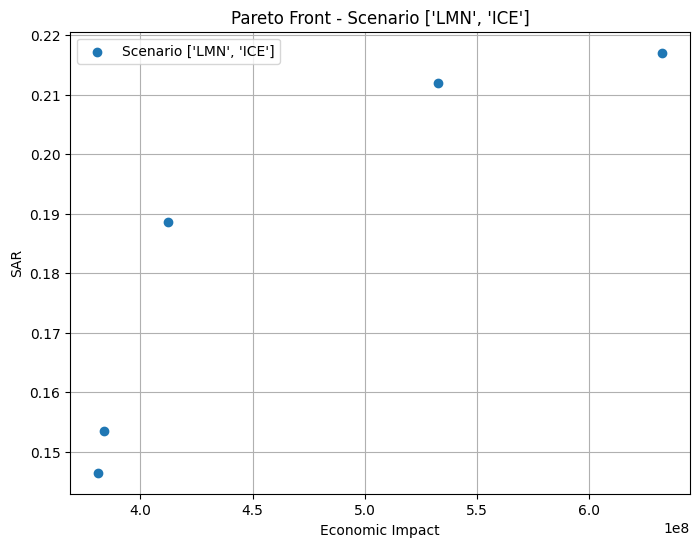

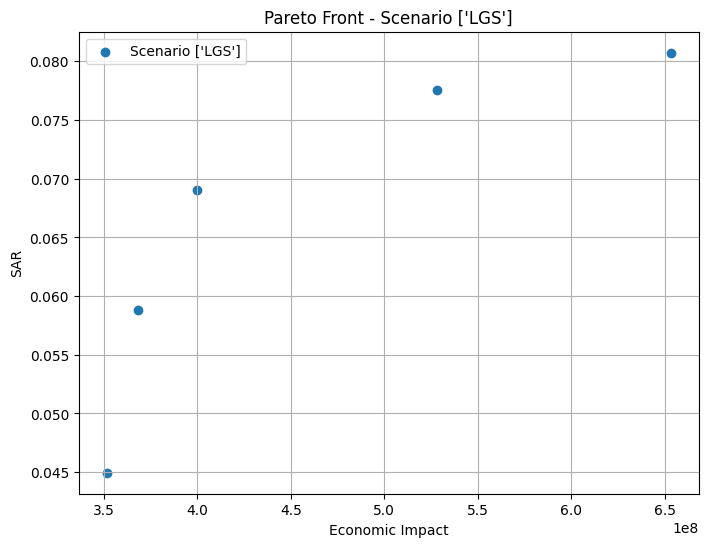

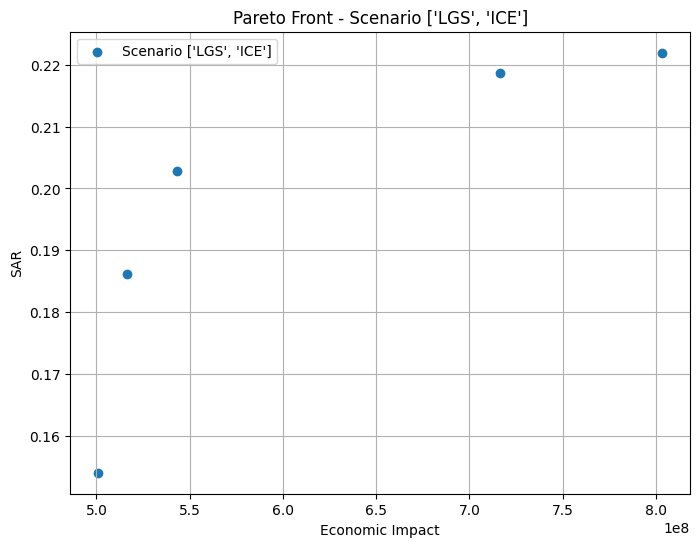

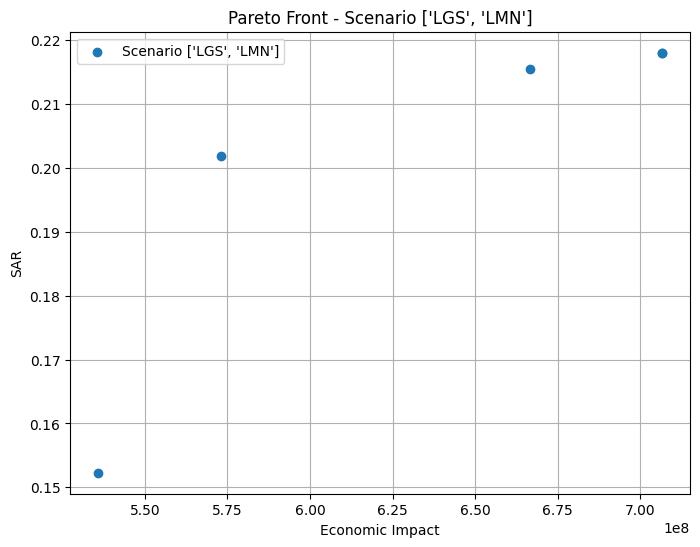

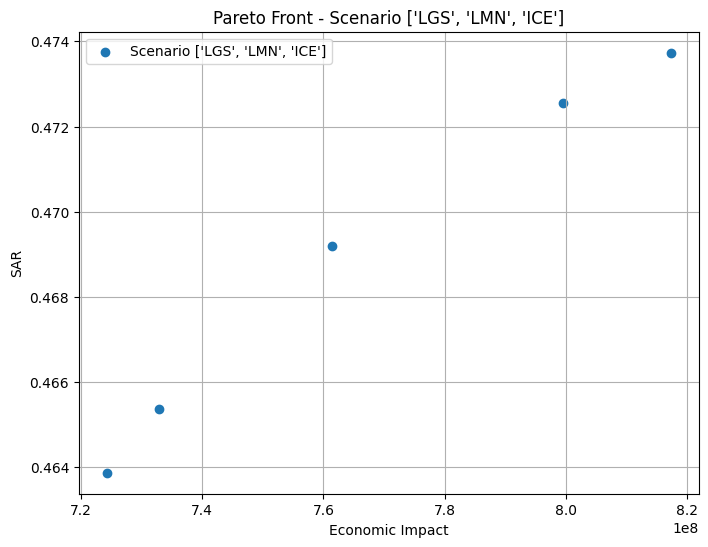

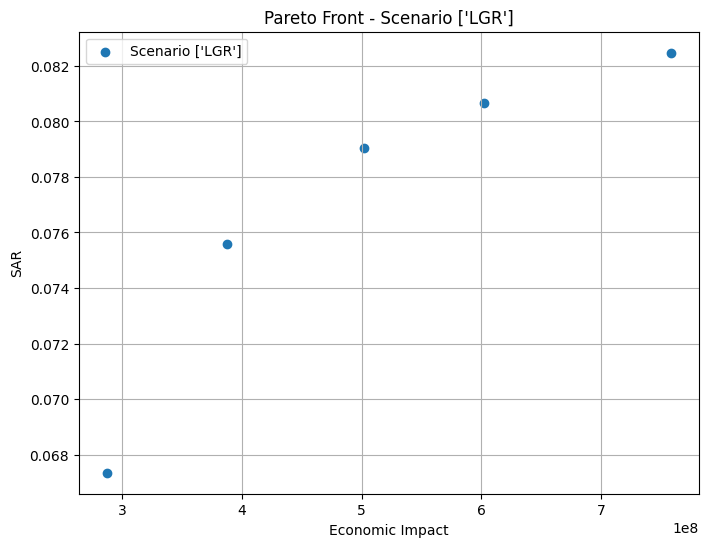

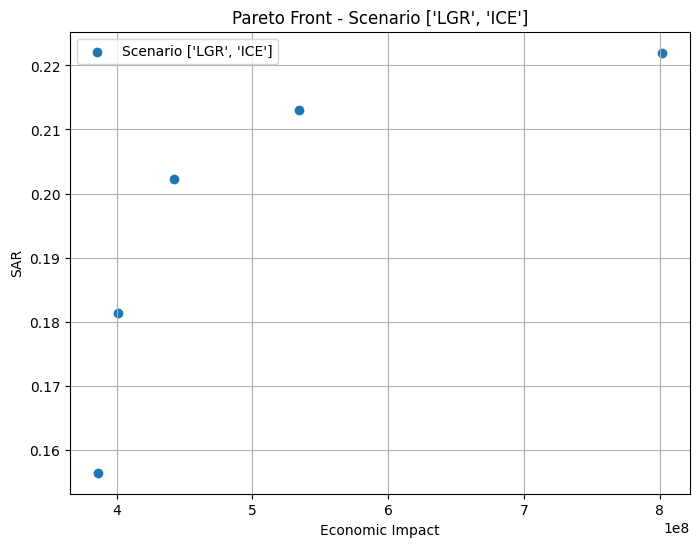

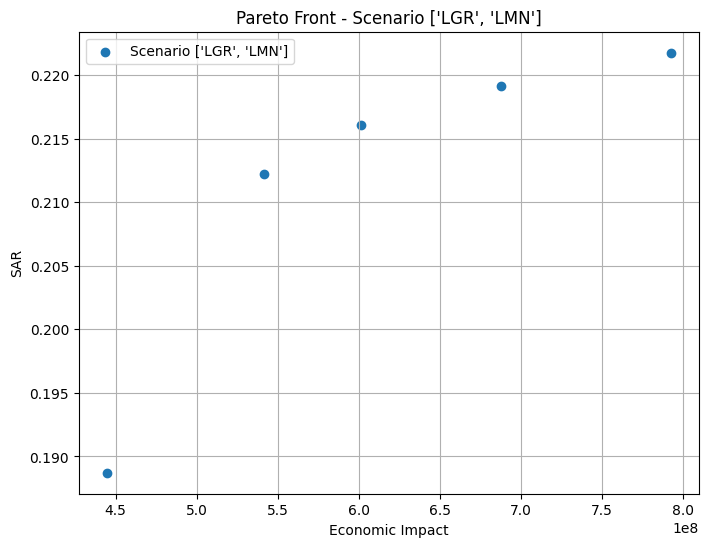

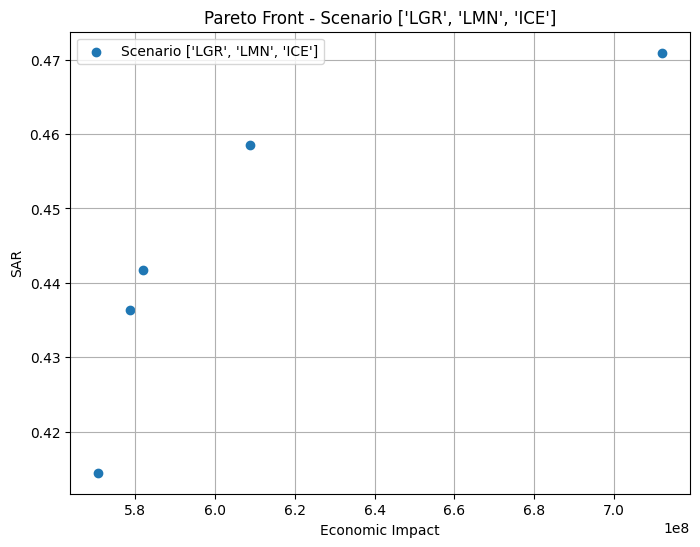

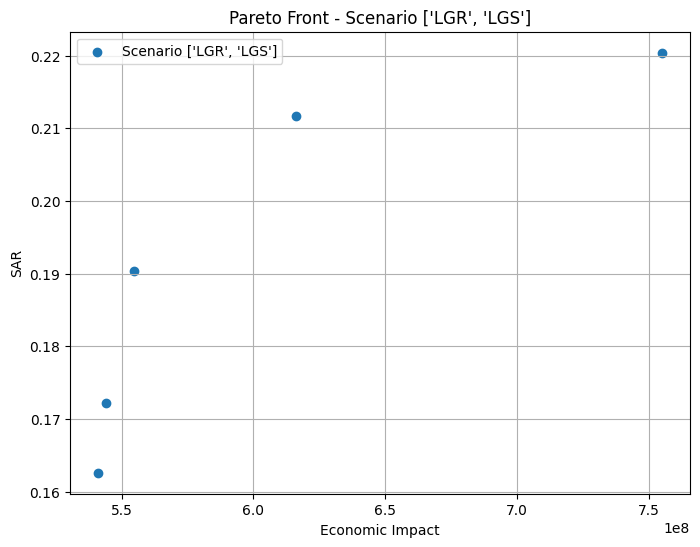

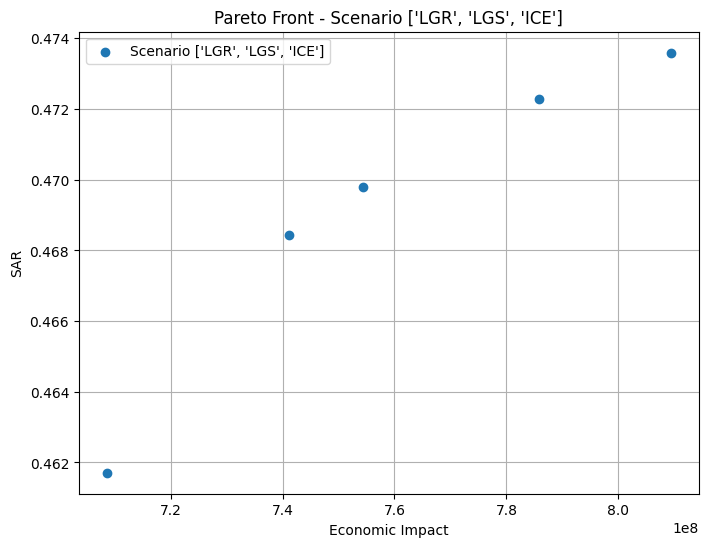

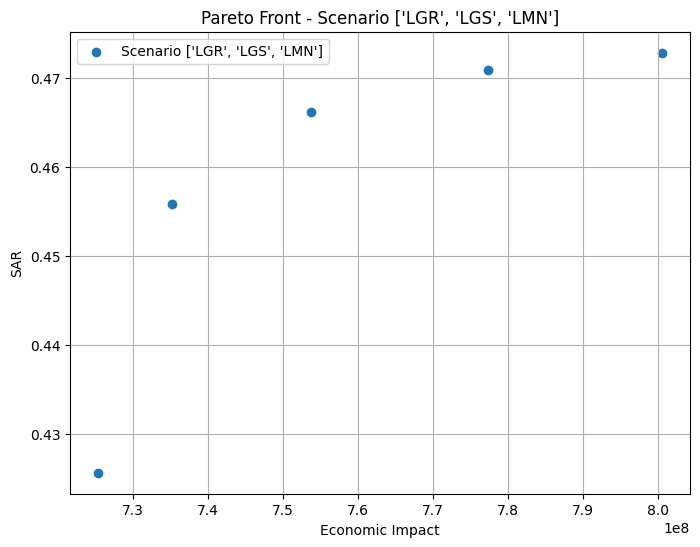

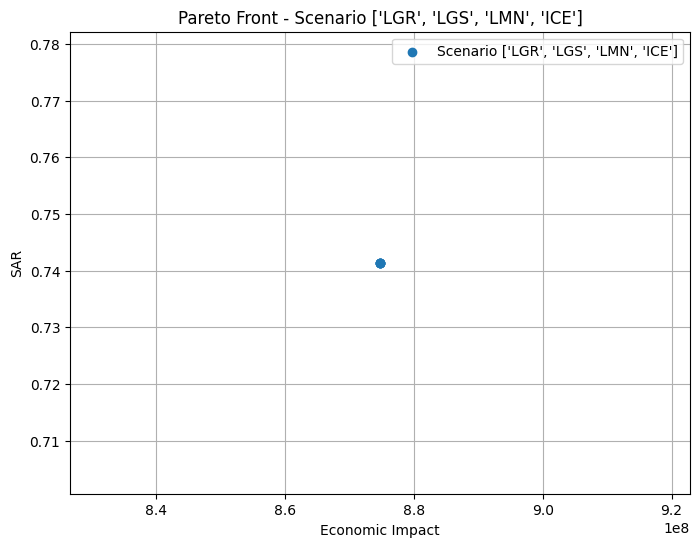

In [18]:
for result in pareto_results:
    scenario = result["scenario"]
    pareto_front = result["pareto_front"]

    sar_values = [fitness[0] for _, fitness in pareto_front]
    econ_values = [fitness[1] for _, fitness in pareto_front]

    plt.figure(figsize=(8, 6))
    plt.scatter(econ_values, sar_values, label=f"Scenario {scenario}")
    plt.title(f"Pareto Front - Scenario {scenario}")
    plt.xlabel("Economic Impact")
    plt.ylabel("SAR")
    plt.legend()
    plt.grid()
    plt.show()